# Assignment 2

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import io
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 6

In [2]:
os.getenv('PUIdata', 'Warning! The data will be saved in your current notebook directory. ' + \
                        'Please make sure your environmental variable, PUIdata is set.')

'/gpfs1/cusp/bs3639/PUIdata'

In [3]:
# Settings / Constants
datestring = '201501'

basename = '{}-citibike-tripdata'.format(datestring)
url = 'https://s3.amazonaws.com/tripdata/{}.zip'.format(basename)
csv_filename = '{}.csv'.format(basename)
cache_path = os.path.join(os.getenv('PUIdata', './'), csv_filename)

In [4]:
# Load file from either url or cache
if os.path.isfile(cache_path):
    print('Loading from local csv file')
    df = pd.read_csv(cache_path)
    
else:
    print('Loading from aws')
    # Get zip buffer
    remotezip = urllib.urlopen(url).read()
    
    # Open in memory
    with zipfile.ZipFile(io.BytesIO(remotezip)) as z:
        # Read the filename or the first file if there are naming inconsistencies
        zip_file_to_read = csv_filename if csv_filename in z.namelist() else z.namelist()[0]
        df = pd.read_csv(z.open(zip_file_to_read))
    
    # Save dataframe as cached 
    df.to_csv(cache_path)

print('{} samples'.format(len(df)))
df.head()

Loading from local csv file
285552 samples


,Unnamed: 0,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


# IDEA:
### Subscribers are more likely to ride their bike during the week than customers.

# NULL HYPOTHESIS:
### The ratio of subscribers biking on weekends to weekdays is _the same_ or _higher_  than the ratio of customers  biking on weekends to weekdays.

# _$H_0$_ : $\frac{P_{cus,wkd}}{P_{cus,wk}} <= \frac{P_{sub,wkd}}{P_{sub,wk}}$
# _$H_A$_ : $\frac{P_{cus,wkd}}{P_{cus,wk}} >  \frac{P_{sub,wkd}}{P_{sub,wk}}$

### I will use a significance level  $\alpha=0.05$

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

In [5]:
# Drop any missing values
data = df.dropna(subset=['usertype', 'starttime']).copy()

# Use starttime as the date
data['date'] = pd.to_datetime(data['starttime'])

# Strip out unrelevant columns
data.drop([
        col for col in data.columns 
        if col not in ['date', 'usertype']
], axis=1, inplace=True)

data.head()

,usertype,date
0,Subscriber,2015-01-01 00:01:00
1,Subscriber,2015-01-01 00:02:00
2,Subscriber,2015-01-01 00:04:00
3,Subscriber,2015-01-01 00:04:00
4,Subscriber,2015-01-01 00:05:00


In [6]:
# Get weekday counts
count_c = data.date[data['usertype'] == 'Customer'].groupby([data.date.dt.weekday]).count()
count_s = data.date[data['usertype'] == 'Subscriber'].groupby([data.date.dt.weekday]).count()

# Replace numerical weekdays with weekday names
daysofweek = dict(enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))
count_c.index = count_c.index.to_series().map(daysofweek)
count_s.index = count_s.index.to_series().map(daysofweek)

# Display data
pd.DataFrame({
    'Customers': count_c,
    'Subscribers': count_s
})

,Customers,Subscribers
date,,
Mon,633,37369
Tue,369,38510
Wed,342,43025
Thu,1177,51728
Fri,1290,56539
Sat,800,27280
Sun,1017,25473


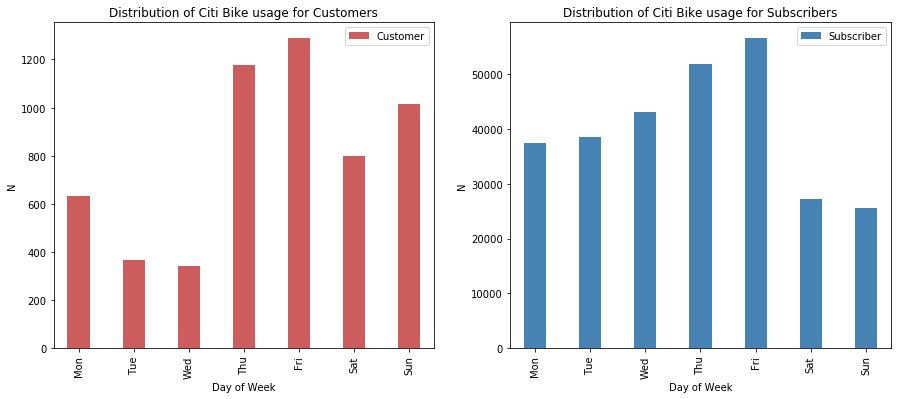

In [7]:
_width = 0.4

# Plot overall counts
plt.subplot(1,2,1)
count_c.plot(kind="bar", color='IndianRed', label='Customer', width=_width)
plt.title('Distribution of Citi Bike usage for Customers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend()

plt.subplot(1,2,2)
count_s.plot(kind="bar", color='SteelBlue', label='Subscriber', width=_width)
plt.title('Distribution of Citi Bike usage for Subscribers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend();

### Figure 1a. Distribution of Citi Bike users by user type in 01/2015, absolute counts

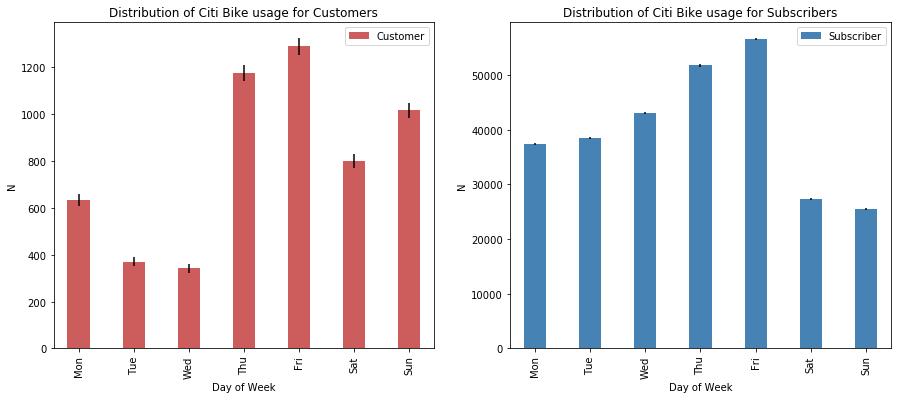

In [8]:
plt.subplot(1,2,1)
count_c.plot(kind="bar",color='IndianRed', width=_width, label='Customer',
                         yerr=[ [np.sqrt(count_c)]*2 ])
plt.title('Distribution of Citi Bike usage for Customers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend()

plt.subplot(1,2,2)
count_s.plot(kind="bar",color='SteelBlue', width=_width, label='Subscriber',
                         yerr=[[np.sqrt(count_s)]*2])
plt.title('Distribution of Citi Bike usage for Subscribers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend();

### Figure 1b. Distribution of Citi Biky users by age and user type in 01/2015, absolute counts, with statistical errors

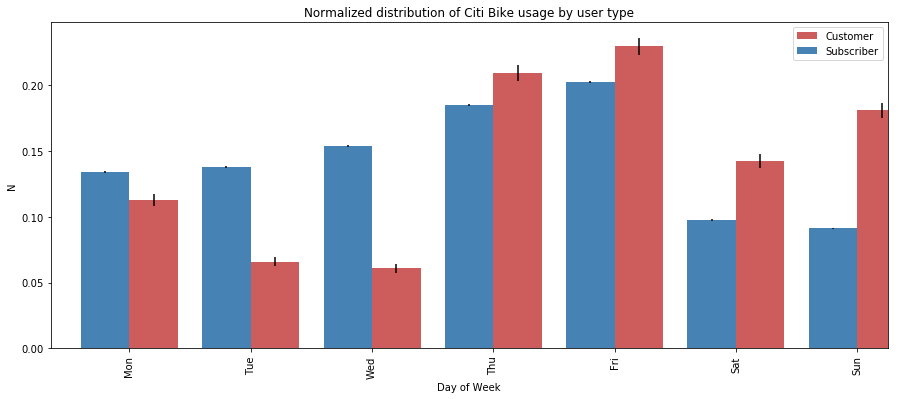

In [9]:
norm_c, norm_s = count_c.sum(), count_s.sum()

(count_c / norm_c).plot(kind="bar",color='IndianRed', position=0, width=_width,
                         yerr=[ [np.sqrt(count_c) / norm_c]*2 ], label='Customer')
(count_s / norm_s).plot(kind="bar",color='SteelBlue', position=1, width=_width,
                         yerr=[ [np.sqrt(count_s) / norm_s]*2 ], label='Subscriber')
plt.title('Normalized distribution of Citi Bike usage by user type')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend();

### Figure 2. Distribution of Citi Biky users by age and user type in 01/2015, normalized